In [1]:
%matplotlib inline
import os
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt

import get
import post
import utils
from field import Field

In [2]:
def set_plt_size(*size):
    plt.rcParams['figure.figsize'] = size

def plot_markers(markers):
    cols = len(markers)
    rows = cols // 10 + 1
    if cols % 10 == 0:
        rows -= 1
    cols = min(10, cols)
    set_plt_size(4 * cols, 4 * rows)
    fix, axs = plt.subplots(rows, cols)
    for i, marker in enumerate(markers):
        if rows > 1:
            axs[i // 10, i % 10].imshow(marker)
            axs[i // 10, i % 10].axis('off')
        else:
            axs[i].imshow(marker)
            axs[i].axis('off')

In [3]:
templates = {}
for filename in os.listdir('./rotated_templates/'):
    num, *_ = filename.split('.')
    img = cv2.imread('./rotated_templates/' + filename, 0)
    templates[num] = img

In [4]:
side = step = 5
image_side = 300
image_step = step * (300 / side)
holes_coords = [(3, 0), (4, 9)]

In [5]:
ids_mapper = {
    1: 1,
    3: 3,
    5: 5,
    6: 6,
    7: 7
}

In [6]:
k = side / 2
top_xyz = {
    1: [0, k * -1, k * 2.134],
    3: [0, 0, k * 1.134],
    5: [0, -k * 0.5, 1.134 * k],
    6: [0, 0, k * 2.134],
    7: [-k * 0.5, -k * 0.5, k * 1.134]
}
LEFT_TOP = [-k, -k, 0]
LEFT_BOTTOM = [-k, k, 0]
RIGHT_TOP = [k, -k, 0]
RIGHT_BOTTOM = [k, k, 0]
img_coord = [[150,0], [0,300], [300,300]]

In [7]:
def recognize(marker):
    results = {}
    for key, template in templates.items():
        id_ = int(key[0])
        if id_ not in ids_mapper:
            continue
        results[key] = cv2.matchTemplate(marker, template, cv2.TM_CCOEFF_NORMED).sum()
    key = max(results, key=lambda key: results[key])
    return int(key[0]), int(key[2:])

In [8]:
s = get.status()
while s != 3:
    time.sleep(1)
    print(s, end='')
    s = get.status()

In [9]:
data = get.fetch()
if not data:
    raise RuntimeError('Stand has dead')
# data = np.load('file.npz')
coords = data['coords']
markers = utils.prepare(data['markers'].astype(np.uint8))

In [10]:
pyramids = []
for (x, y), marker in zip(coords, markers):
    id_, rot = recognize(marker)
    if id_ not in top_xyz:
        id_ = 3
    pyramids.append([int(x), int(y), rot, id_])

In [11]:
print(post.figures(pyramids, ids_mapper).content)

b'{"status":"ok","error":null}'


In [12]:
len(markers)

10

In [13]:
s = get.status()
while s != 4:
    time.sleep(1)
    print(s, end='')
    s = get.status()

In [14]:
pyramids = np.array(pyramids)

In [15]:
projector = (20, 25, 148.14)
field = Field(step, side, *projector)

In [16]:
projections = []
for a, b, rot, id_ in pyramids:
    top = np.array(top_xyz[id_])
    if rot == 90:
        top[1], top[0] = -top[0], top[1]
    elif rot == 180:
        top[:2] *= -1
    elif rot == 270:
        top[1], top[0] = top[0], -top[1]
    faces = [
        [top, LEFT_TOP, RIGHT_TOP],
        [top, RIGHT_TOP, RIGHT_BOTTOM],
        [top, RIGHT_BOTTOM, LEFT_BOTTOM],
        [top, LEFT_BOTTOM, LEFT_TOP]
    ]
    center = np.array([a * step + side / 2, b * step + side / 2, 0])
    faces = np.array(faces) + center
    projections.append([]) # pyra level
    for face in faces:
        projections[-1].append([]) # face level
        for x, y, z in face: # point level
            xp, yp = field.find_dot_projection(x, y, z)
            projections[-1][-1].append([xp, yp, 0])
projections = np.array(projections)

for i, (a, b) in enumerate(coords):
    center = np.array([a * step + side / 2, b * step + side / 2, 0])
    for j in range(4):
        for k in range(3):
            projections[i, j, k] -= center - side / 2

# drop z
projections = np.round(projections, 5)[:, :, :, :2]

projections *= 300 / side

In [17]:
bg = cv2.imread('./textures/bg.jpg')
hole = cv2.imread('./textures/hole.jpg')
planets = {}
for filename in os.listdir('./textures/'):
    if 'planet' not in filename:
        continue
    id_ = int(filename[6])
    planets[id_] = cv2.imread(f'./textures/{filename}')

In [18]:
face_projs = []
for i, (_, _, rot, id_) in enumerate(pyramids):
    affines = []
    img = np.uint8(planets[id_])
#     img[:, :] = (0, 0, 0)
    for j in range(4):
        pts1  = np.float32(img_coord)
        pts2  = np.float32(projections[i][j])
        matrix = cv2.getAffineTransform(pts1, pts2)
        result = cv2.warpAffine(img, matrix, (300, 300))
#         result = cv2.circle(result, tuple(pts2[0].astype(int)), 20, (255, 255, 255), -1)
        affines.append(result)
    affines = np.array(affines)
    face_projs.append([affines.sum(axis=0)])
face_projs = np.concatenate(face_projs, axis=0)

In [19]:
package = bg.copy()
# package[:,:] = np.random.randint(0,255,size=(3,))

# Holes render
for x, y in holes_coords:
    y0, x0 = (np.array([x, y]) * image_step).astype(int)
    old = package[x0:x0 + image_side, y0:y0 + image_side]
    for i in range(image_side):
        for j in range(image_side):
            if hole[i, j, :].sum() > 10:
                old[i, j] = hole[i, j]
    package[x0:x0 + image_side, y0:y0 + image_side] = old

for projection, coordinates in zip(face_projs, coords):
    x0, y0 = (coordinates * image_step).astype(int)
    package[x0:x0 + image_side, y0:y0 + image_side] = projection

cv2.line(package, (0, 1500), (2400, 1500), (255, 255, 255), thickness=10)
package = package[::-1, ::-1]

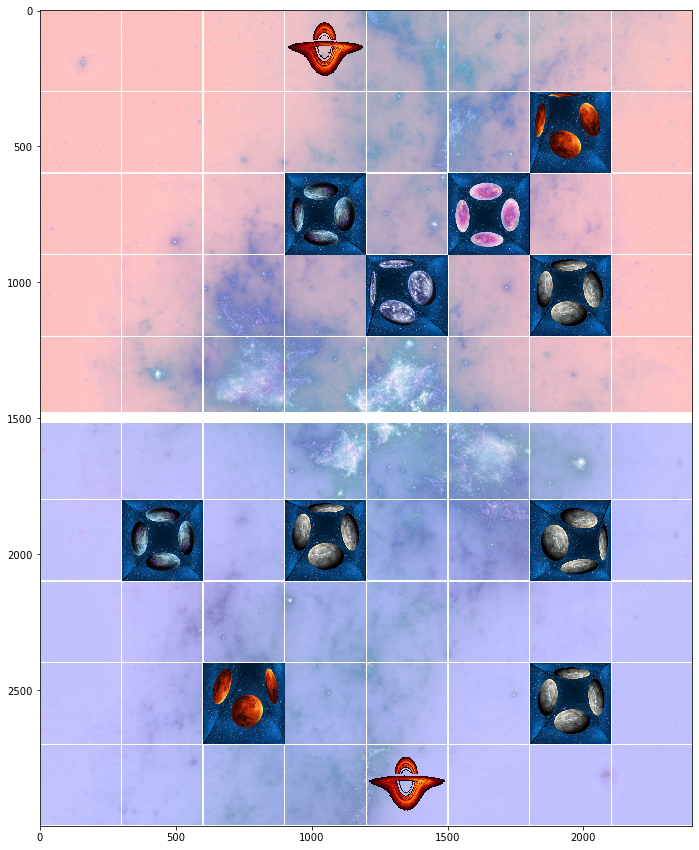

In [20]:
set_plt_size(12, 15)
plt.imshow(cv2.cvtColor(package, cv2.COLOR_BGR2RGB))

In [21]:
package = cv2.resize(package, (1200, 1500))
res = post.send(package)
print(res.json())

{'status': 'ok', 'error': None}


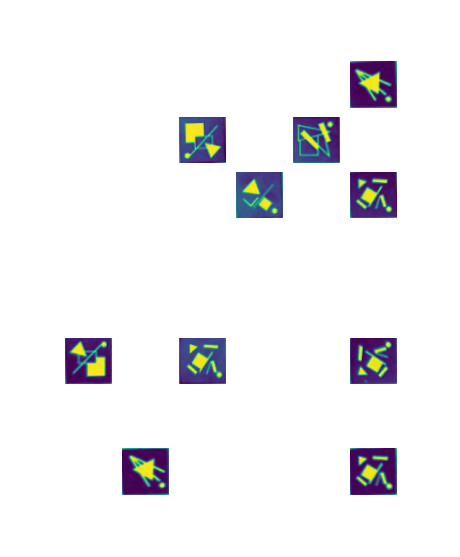

In [22]:
set_plt_size(8, 10)
fig, axs = plt.subplots(10, 8)
axs = axs[::-1, ::-1]
for (y, x), m in zip(coords, data['markers']):
    axs[y, x].imshow(m)
for ax in axs.flatten():
    ax.axis('off')

In [23]:
rots = np.zeros((10, 8))
for x, y, rot, _ in pyramids:
    rots[x, y] = rot
rots = rots[::-1, ::-1]

ids = np.zeros((10, 8))
for x, y, _, id_ in pyramids:
    ids[x, y] = id_
ids = ids[::-1, ::-1]

for r1, r2 in zip(rots, ids):
    for c1, c2 in zip(r1, r2):
        print(f'{int(c2)}-{int(c1):->3}', end='   ')
    print()

0---0   0---0   0---0   0---0   0---0   0---0   0---0   0---0   
0---0   0---0   0---0   0---0   0---0   0---0   1-180   0---0   
0---0   0---0   0---0   6-270   0---0   3--90   0---0   0---0   
0---0   0---0   0---0   0---0   7-180   0---0   5-180   0---0   
0---0   0---0   0---0   0---0   0---0   0---0   0---0   0---0   
0---0   0---0   0---0   0---0   0---0   0---0   0---0   0---0   
0---0   6--90   0---0   5-180   0---0   0---0   5--90   0---0   
0---0   0---0   0---0   0---0   0---0   0---0   0---0   0---0   
0---0   0---0   1-180   0---0   0---0   0---0   5-180   0---0   
0---0   0---0   0---0   0---0   0---0   0---0   0---0   0---0   
